# Benchmarking: Visualize Train Performance
## Select Env

In [3]:
import sys
from pathlib import Path
import seaborn as sns
import pandas as pd

sys.path.append("/home/benjamin/Dokumente/code/tmp/tntcomp/CARL")

env_name = "CARLMountainCarEnv"
env_name = "CARLPendulumEnv"
eval_data_fn = f"/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/eval_data_benchmarking_{env_name}.pickle"
plot_data_fn = Path(eval_data_fn).parent / (Path(eval_data_fn).stem + "_plot.csv")


config_keys = ["wandb.group", "seed", "context_sampler.sigma_rel", "context_sampler.context_feature_names"]

wandb_key_translator = {
    "wandb.group": "visibility",
    "context_sampler.sigma_rel": "$\sigma_{rel}$",
    "context_sampler.context_feature_names": "C",
    "train/global_step": "$k$",
    "eval/return": "$R$"
}
wkt = wandb_key_translator


def get_palette_visibility(df: pd.DataFrame) -> dict:
    key = "wandb.group" if "wandb.group" in df else wkt["wandb.group"]
    unique = df[key].unique()
    palette = dict(zip(unique, sns.color_palette(palette="colorblind", n_colors=len(unique))))
    return palette


def load_plot_df(plot_data_fn: str) -> pd.DataFrame:
    plot_df = pd.read_csv(plot_data_fn)
    print(plot_df.columns)
    plot_df.rename(columns=wandb_key_translator, inplace=True)
    plot_df.sort_values(by=[wkt["wandb.group"], wkt["context_sampler.context_feature_names"]], inplace=True)
    return plot_df

## Download Data
From wandb.

In [5]:
from tqdm import tqdm
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
filters = {
    "config.env": env_name,
    "config.experiment": "benchmarking",
    "config.wandb.job_type": "train",
    # "config.context_sampler.n_samples": 1000,
    "state": "finished",
}
metrics = ["eval/return", "train/global_step"]
runs = api.runs("tnt/carl-tmlr", filters=filters)

summary_list, config_list, name_list, metrics_list = [], [], [], []
for run in tqdm(runs, total=len(runs)):
    # Check metrics first. If not all available, do not append run
    rows = []
    for i, row in run.history(keys=metrics).iterrows():
        if all([metric in row for metric in metrics]):
            # df = df.append(row, ignore_index=True)
            rows.append(row)
        else:
            continue
    df = pd.DataFrame(rows)
    metrics_list.append(df)
    
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)


runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "metrics": metrics_list,
    })

runs_df.to_pickle(eval_data_fn)


100%|██████████| 989/989 [03:32<00:00,  4.64it/s]


## Convert Data to Plot

In [6]:
import sys
sys.path.append("../..")
import pandas as pd
import ast
from rich import print as printr
from rich.progress import track
from ast import literal_eval
from pathlib import Path
from omegaconf import OmegaConf
from tqdm import tqdm


runs_df = pd.read_pickle(eval_data_fn)

plot_df = []
for idx, content in tqdm(runs_df.iterrows(), total=len(runs_df)):
    cfg = OmegaConf.create(content["config"])
    config_entries = {k: eval("cfg." + k) for k in config_keys}
    metrics = content["metrics"]
    n_points = len(metrics)
    for k, v in config_entries.items():
        metrics[k] = [v] * n_points
    plot_df.append(metrics)

plot_df = pd.concat(plot_df)
plot_df.to_csv(plot_data_fn, index=False)



100%|██████████| 989/989 [00:05<00:00, 177.03it/s]


## Plot Combined, differ. by sigma

Index(['_step', 'eval/return', 'train/global_step', 'wandb.group', 'seed',
       'context_sampler.sigma_rel', 'context_sampler.context_feature_names'],
      dtype='object')


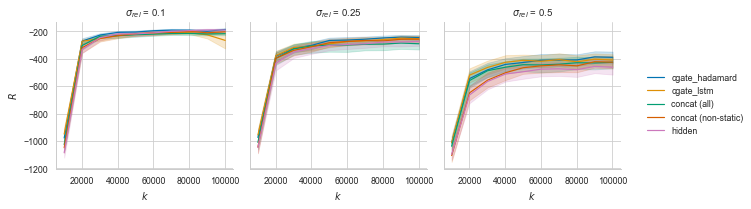

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_fn = f"data/{env_name}_differsigma.png"

sns.set_style("whitegrid")
sns.set_context("paper")#, font_scale=1)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.sigma_rel"]]

grid = sns.FacetGrid(data=plot_df, col=group_keys[0], legend_out=True)
grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette)
grid.add_legend()
grid.tight_layout()

grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

# if env_name == "CARLPendulumEnv":
#     ylim = (-600, -180)
#     _ = [ax.set_ylim(*ylim) for ax in grid.axes.flatten()]


## Plot for each sigma, diff grids by changing cf, hue: visibility

Index(['_step', 'eval/return', 'train/global_step', 'wandb.group', 'seed',
       'context_sampler.sigma_rel', 'context_sampler.context_feature_names'],
      dtype='object')


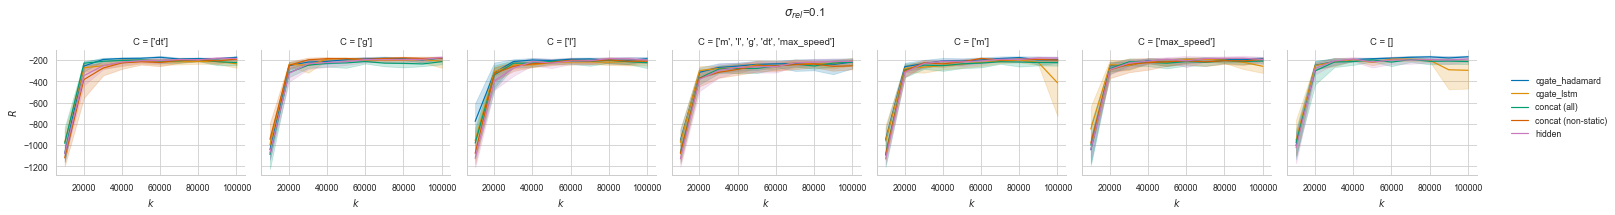

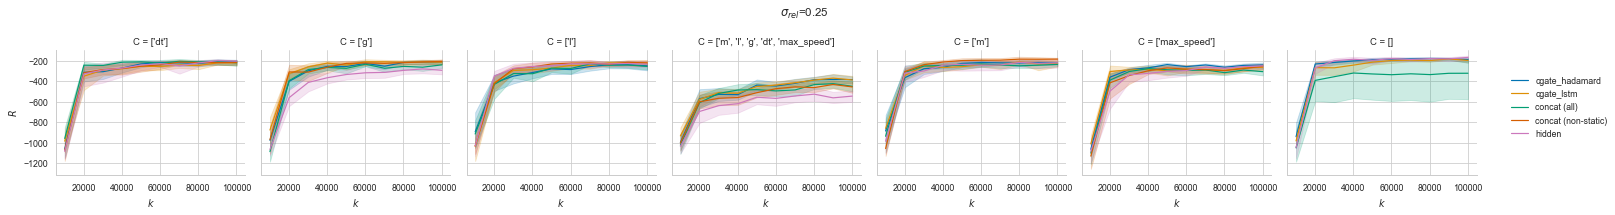

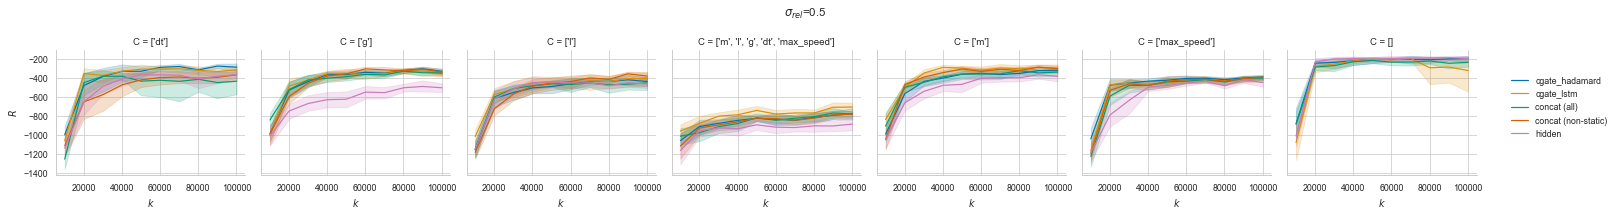

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")#, font_scale=1)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
groups = plot_df.groupby(wkt["context_sampler.sigma_rel"])

for group_id, group_df in groups:
    group_keys = [wkt["context_sampler.context_feature_names"]]
    grid = sns.FacetGrid(data=group_df, col=group_keys[0], legend_out=True)
    grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette)
    grid.add_legend()
    grid.figure.suptitle(f"{wkt['context_sampler.sigma_rel']}={group_id}")
    grid.tight_layout()

    fig_fn = f"data/{env_name}_differcontextfeatures_{group_id}.png"
    grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

In [13]:
import numpy as np
from tqdm import tqdm
from collections import OrderedDict


def fill_trajectory(performance_list, time_list, replace_nan=np.NaN):
    if len(performance_list) < 2:
        return np.array(performance_list), np.array(time_list).flatten()

    frame_dict = OrderedDict()
    counter = np.arange(0, len(performance_list))
    for p, t, c in zip(performance_list, time_list, counter):
        if len(p) != len(t):
            raise ValueError("(%d) Array length mismatch: %d != %d" %
                             (c, len(p), len(t)))
        frame_dict[str(c)] = pd.Series(data=p, index=t)

    merged = pd.DataFrame(frame_dict)
    merged = merged.ffill()

    performance = merged.to_numpy()
    time_ = merged.index.values

    performance[np.isnan(performance)] = replace_nan
    if not np.isfinite(performance).all():
        raise ValueError("\nCould not merge lists, because \n"
                         "\t(a) one list is empty?\n"
                         "\t(b) the lists do not start with the same times and"
                         " replace_nan is not set?\n"
                         "\t(c) replace_nan is not set and there are non valid "
                         "numbers in the list\n"
                         "\t(d) any other reason.")

    return performance, time_


group_keys = [wkt.get(k, k) for k in config_entries]
groups = plot_df.groupby(group_keys)
performance_list, time_list, meta_list = [], [], []
for group_id, group_df in groups:
    time_list.append(group_df[wkt["train/global_step"]].to_numpy())
    performance_list.append(group_df[wkt["eval/return"]].to_numpy())
    meta_list.append(group_id)

for i in time_list:
    i[0] = 10000
performance_list_transformed, time_list_transformed = fill_trajectory(performance_list=performance_list, time_list=time_list)


plot_df_transformed = pd.DataFrame({
    wkt["train/global_step"]: np.concatenate([time_list_transformed] * performance_list_transformed.shape[-1]),
    wkt["eval/return"]: performance_list_transformed.flatten(),
})

n_points = performance_list_transformed.shape[0]
tiles = np.concatenate([np.tile(meta_list[i], n_points).reshape(-1, len(meta_list[i])) for i in range(len(meta_list))])
for i, k in enumerate(group_keys):
    plot_df_transformed[k] = tiles[:, i]


group_keys = [wandb_key_translator["context_sampler.sigma_rel"]]

grid = sns.FacetGrid(data=plot_df_transformed, col=group_keys[0])
grid.map_dataframe(sns.lineplot, x=wandb_key_translator["train/global_step"], y=wandb_key_translator["eval/return"], hue=wandb_key_translator["wandb.group"])


KeyError: 'visibility'